The German credit dataset is a standard imbalanced classification dataset that has thisproperty of differing costs to misclassification errors.  Models evaluated on this dataset can beevaluated using the Fbeta-measure that provides a way of both quantifying model performancegenerally, and captures the requirement that one type of misclassification error is more costlythan another. 

#### German Credit Dataset

The German credit dataset describes financial and banking details for customers and thetask is to determine whether the customer is good or bad.  The assumption is that the taskinvolves predicting whether a customer will pay back a loan or credit.  The dataset includes1,000 examples and 20 input variables, 7 of which are numerical (integer) and 13 are categorical.

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import fbeta_score 
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks, RepeatedEditedNearestNeighbours, NeighbourhoodCleaningRule, OneSidedSelection


sns.set()

In [13]:
#url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/german.csv"
path = "data/german_credit.csv"
data = pd.read_csv(path, index_col=0)

#### Explore the dataset 



In [14]:
for idx, val in data.iloc[:,-1].value_counts().iteritems():
    print("Class={}, Count={}, Percentage={}%".format(idx, val, (val/ data.shape[0]) * 100))

Class=1, Count=700, Percentage=70.0%
Class=2, Count=300, Percentage=30.0%


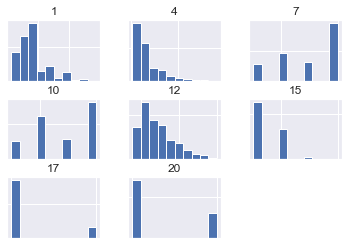

In [15]:
# distribution fro numerical types
num_cols = data.select_dtypes(include = ['int64', 'float64']).columns
subset = data[num_cols]
ax = subset.hist();
for axis in ax.flatten():
    axis.set_xticklabels([])
    axis.set_yticklabels([])    

#### Model Test and Baseline Result

We will predict class labels of whether a customer is good or not.  Therefore, we need ameasure that is appropriate for evaluating the predicted class labels.  The focus of the task is onthe positive class (bad customers).  Precision and recall are a good place to start.  Maximizing precision will minimize the false positives and maximizing recall will minimize the false negatives in the predictions made by a model.

In this particular case is that false negatives are more damaging thanfalse positives.  Remember that false negatives on this dataset are cases of a bad customer being marked as a good customer and being given a loan.
We want to favor models that arebetter are minimizing false negatives over false positives.  This can be achieved by using a versionof the F-measure that calculates a weighted harmonic mean of precision and recall but favorshigher recall scores over precision scores.

 This is called the Fbeta-measure, a generalization ofF-measure, wherebetais a parameter that defines the weighting of the two scores.  Abetavalueof 2 will weight more attention on recall than precision and is referred to as the F2-measure.
 
   The F2-measure from this prediction provides a baseline in model performanceon this problem by which all other models can be compared.  This can be achieved using theDummyClassifierclass from the scikit-learn library and setting thestrategyargument to‘constant’and theconstantargument to1for the minority class.


In [16]:
def load_dataset(full_path):
    df = pd.read_csv(full_path, index_col=0)
    X, y =df.iloc[:,:-1], df.iloc[:,-1]
    cat_ix = X.select_dtypes(include=['object', 'bool']).columns
    # one hot encode cat features only
    ct = ColumnTransformer([('o', OneHotEncoder(), cat_ix)], remainder='passthrough')
    X = ct.fit_transform(X)
    y = LabelEncoder().fit_transform(y) #0, 1 encoding
    return X, y

def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

def evaluate_model(X, y, model):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    metric = make_scorer(f2_measure)
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    return scores

X1, y1 = load_dataset(full_path=path)
print(X.shape, y.shape, Counter(y))
model = DummyClassifier(strategy='constant', constant=1)
scores = evaluate_model(X=X, y=y, model=model)
print("Mean F2: {:.3f} +/- ({:.3f})".format(np.mean(scores), np.std(scores)))

(1000, 20) (1000,) Counter({0: 700, 1: 300})
Mean F2: 0.682 +/- (0.000)


We can see that we havethe correct number of rows loaded, and through the one hot encoding of the categorical inputvariables, we have increased the number of input variables from 20 to 61.  That suggests that the 13 categorical variables were encoded into a total of 54 columns.

We can see that the class labels have the correct mapping to integers with 0 forthe majority class and 1 for the minority class, customary for imbalanced binary classificationdataset.

Next, the average of the F2-measure scores is reported.  In this case, we can see thatthe baseline algorithm achieves an F2-measure of about 0.682.  This score provides a lower limiton model skill; any model that achieves an average F2-measure above about 0.682 has skill,whereas models that achieve a score below this value do not have skill on this dataset.

#### Evaluate Models

It can be a good idea to spot-check a suite of different linear and nonlinear algorithms on adataset to quickly flush out what works well and deserves further attention, 

In [17]:
def get_models():
    models = {}
    models['LR'] = LogisticRegression(solver='liblinear')
    models['LDA'] = LinearDiscriminantAnalysis()
    models['GNB'] = GaussianNB()
    models['SVM'] = SVC(gamma='scale')
    models['GPC'] = GaussianProcessClassifier()
    return models

def load_dataset(full_path):
    df = pd.read_csv(full_path, index_col=0)
    X, y =df.iloc[:,:-1], df.iloc[:,-1]
    cat_ix = X.select_dtypes(include=['object', 'bool']).columns.astype('int')# csv load
    num_ix = X.select_dtypes(include=['int64', 'float64']).columns.astype('int')
    y = LabelEncoder().fit_transform(y) #0, 1 encoding
    return X.values, y, cat_ix, num_ix # idx needs to be int as np arrays are passed


We will one hot encode the categorical input variables as we did in the previous section, and in this case, we will normalize the numerical input variables.  This is bestperformed using the `MinMaxScaler` within each fold of the cross-validation evaluation process.An easy way to implement this is to use a Pipeline where the first step is a `ColumnTransformer` that applies a `OneHotEncoder` to just the categorical variables, and a `MinMaxScaler` to just thenumerical input variables.

In [18]:
X, y, cat_ix, num_ix = load_dataset(full_path=path)
results = {}
for name, model in get_models().items():
    ct = ColumnTransformer(transformers=[
        ('c', OneHotEncoder(), cat_ix),
        ('n', MinMaxScaler(), num_ix)
    ])
    pipeline = Pipeline(steps = [
        ('t', ct),
        ('m',model)
    ])
    scores = evaluate_model(X, y, pipeline)
    results[name] = scores
    print("{}, {:.3f} ({:.3f})".format(name, np.mean(results[name]), np.std(results[name])))

LR, 0.497 (0.072)
LDA, 0.519 (0.072)
GNB, 0.639 (0.049)
SVM, 0.436 (0.077)
GPC, 0.219 (0.061)


In this case, we can see that none of the tested models have an F2-measure above the defaultof predicting the majority class in all cases (0.682).  **None of the models are skillful.  This is surprising, although suggests that perhaps the decision boundary between the two classes is noisy.**

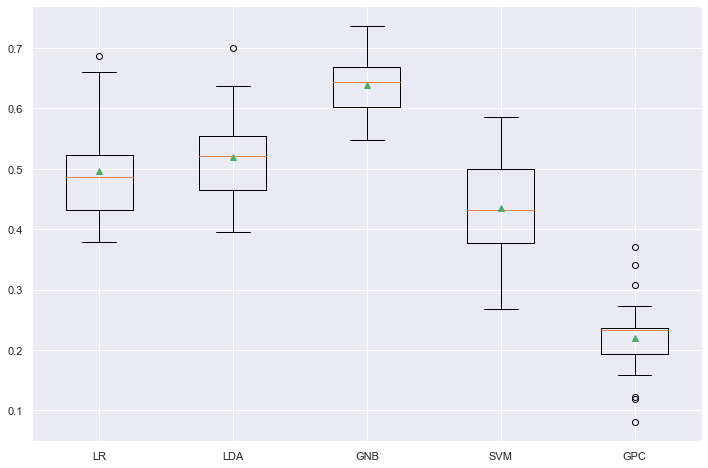

In [19]:
pyplot.figure(figsize=(12,8))
pyplot.boxplot(results.values(), 
               labels=results.keys(), showmeans=True);

### Evaluate Undersampling

Undersampling can help to remove examples from the majority class along the decision boundarythat make the problem challenging for classification algorithms. In this experiment we will testthe following undersampling algorithms:

- Tomek links
- Edited Neareast Neighbors
- repeated Edited Neareast Neighbors
- One Side Selection
- Neighborhood Cleaning Rule

The Tomek Links and ENN methods select examples from the majority class to delete,whereas OSS and NCR both select examples to keep and examples to delete.  We will use thecost-sensitive version of the logistic regression algorithm to test each undersampling methodin an effort to further lift model performance. 


>TL 0.669 (0.057)
>ENN 0.706 (0.048)
>RENN 0.714 (0.041)
>OSS 0.673 (0.056)
>NCR 0.693 (0.052)


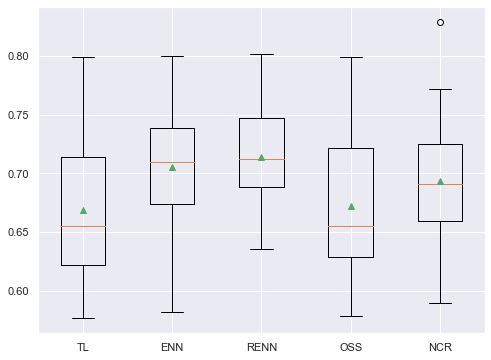

In [25]:
def get_models():
    models = {}
    models['TL'] = TomekLinks()
    models['ENN'] = EditedNearestNeighbours()
    models['RENN'] =RepeatedEditedNearestNeighbours()
    models['OSS'] = OneSidedSelection()
    models['NCR'] = NeighbourhoodCleaningRule()
    return models


results = {}
for name, under in get_models().items():
    model = LogisticRegression(solver='liblinear', class_weight='balanced')
    ct = ColumnTransformer([
    ('c', OneHotEncoder(), cat_ix), 
    ('n', MinMaxScaler(), num_ix)
     ])
    pipeline = Pipeline([
        ('t', ct),
        ('us', under),
        ('m', model)
    ])
    scores = evaluate_model(X, y, pipeline)
    results[name] = scores
    print(">%s %.3f (%.3f)" % (name, np.mean(scores), np.std(scores)))

pyplot.figure(figsize=(8, 6))
pyplot.boxplot(results.values(), 
               labels=results.keys(), showmeans=True);

Box and whisker plots are created for each evaluated undersampling technique, showingthat they generally have the same spread.  It is encouraging to see that for the well performingmethods, the boxes spread up around 0.8, and the mean and median for all three methods arearound 0.7.  This highlights that the distributions are skewing high and are let down on occasionby a few bad evaluations.

###  Make Prediction on New Data

Given the variance in results, a selection of any of the undersampling methods is probablysufficient.  In this case, we will select logistic regression with Repeated ENN. This model had anF2-measure of about about 0.716 on our test harness.  We will use this as our final model anduse it to make predictions on new data.  

In [48]:
model = LogisticRegression(solver='liblinear', class_weight= 'balanced')
ct = ColumnTransformer([
    ('c', OneHotEncoder(), cat_ix), 
    ('n', MinMaxScaler(), num_ix)
     ])
pipeline = Pipeline([
        ('t', ct),
        ('us', RepeatedEditedNearestNeighbours()),
        ('m', model)
    ])
    
pipeline.fit(X,y)

bad_customers = data.loc[data['20'] == 2].drop(columns='20').sample(20).values
good_customers = data[data['20'] == 1].drop(columns='20').sample(20).values

In [49]:
for good_row, bad_row in zip(good_customers,bad_customers):
    yhat = pipeline.predict([good_row])
    label = yhat[0]
    print(">Predicted=%d (expected 0)" % (label))
    yhat = pipeline.predict([bad_row])
    label = yhat[0]
    print(">Predicted=%d (expected 1)" % (label))

>Predicted=0 (expected 0)
>Predicted=1 (expected 1)
>Predicted=0 (expected 0)
>Predicted=1 (expected 1)
>Predicted=0 (expected 0)
>Predicted=1 (expected 1)
>Predicted=0 (expected 0)
>Predicted=1 (expected 1)
>Predicted=1 (expected 0)
>Predicted=1 (expected 1)
>Predicted=1 (expected 0)
>Predicted=1 (expected 1)
>Predicted=1 (expected 0)
>Predicted=1 (expected 1)
>Predicted=0 (expected 0)
>Predicted=1 (expected 1)
>Predicted=1 (expected 0)
>Predicted=0 (expected 1)
>Predicted=0 (expected 0)
>Predicted=1 (expected 1)
>Predicted=0 (expected 0)
>Predicted=1 (expected 1)
>Predicted=1 (expected 0)
>Predicted=1 (expected 1)
>Predicted=0 (expected 0)
>Predicted=1 (expected 1)
>Predicted=1 (expected 0)
>Predicted=1 (expected 1)
>Predicted=1 (expected 0)
>Predicted=1 (expected 1)
>Predicted=0 (expected 0)
>Predicted=1 (expected 1)
>Predicted=1 (expected 0)
>Predicted=1 (expected 1)
>Predicted=1 (expected 0)
>Predicted=1 (expected 1)
>Predicted=0 (expected 0)
>Predicted=1 (expected 1)
>Predicted=1